# Plant Seedling Classification Project
## Anish Indukur

## Importing Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf

# Keras Sequential Model
from tensorflow.keras.models import Sequential

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD

# The below code can be used to ignore the warnings that may occur due to deprecations
import warnings
warnings.filterwarnings("ignore")

2023-06-04 03:16:13.515935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
labels = pd.read_csv('/Users/anish/Desktop/School/AIML/Datasets/Labels.csv')

In [5]:
labelsArr = labels['Label'].values

In [6]:
images = np.load('/Users/anish/Desktop/School/AIML/Datasets/images.npy')
images.shape

(4750, 128, 128, 3)

Images are in color with 3 channels, 128 by 128 resolution.

## Exploratory Data Analysis

The following code will print 9 random pictures and their labels:

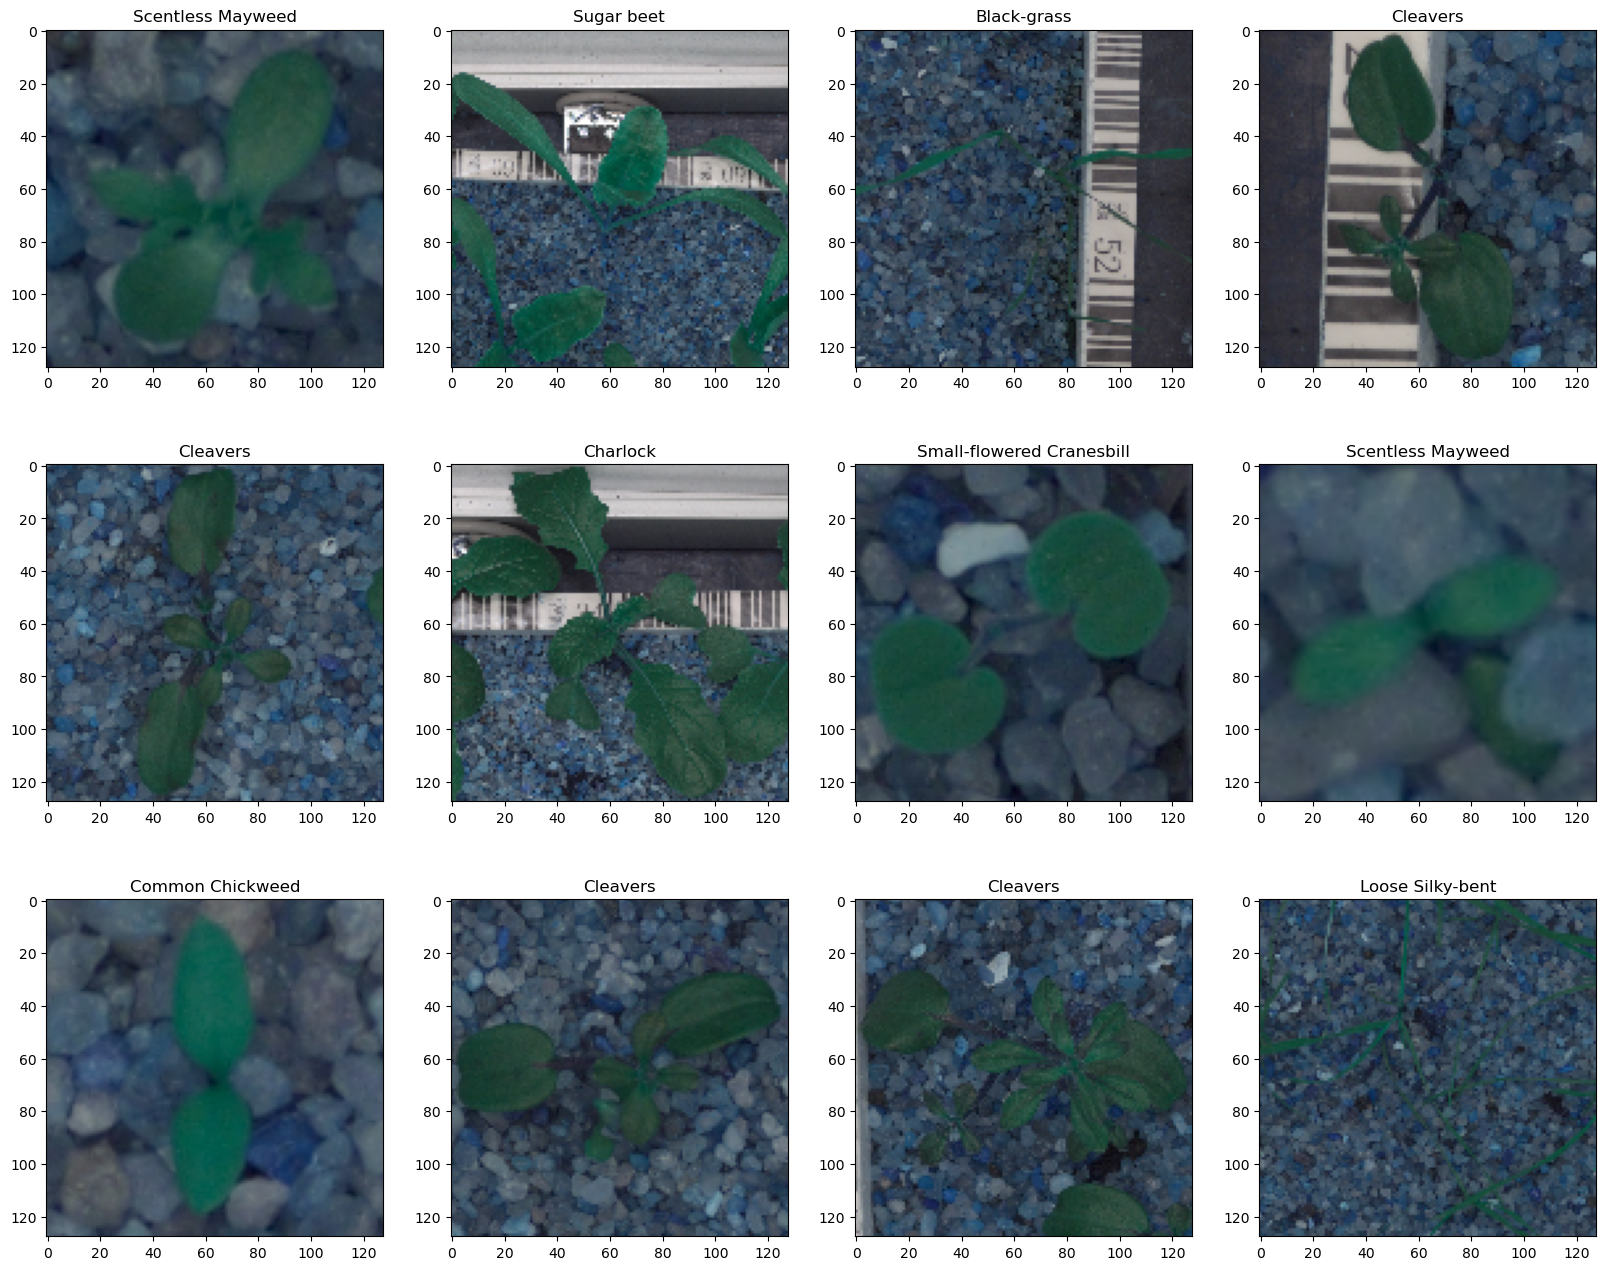

In [5]:
num_classes=12                                                                  # Number of Classes
categories=np.unique(labelsArr)                                                    # Obtaing the unique classes from y_train
rows = 3                                                                        # Defining number of rows=3
cols = 4                                                                        # Defining number of columns=4
fig = plt.figure(figsize=(20, 16))                                               # Defining the figure size to 10x8
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(labelsArr))                       # Generating random indices from the data and plotting the images
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
        ax.imshow(images[random_index, :], cmap=plt.get_cmap('gray'))          # Plotting the image using cmap=gray
        ax.set_title(labelsArr[random_index])
plt.show()

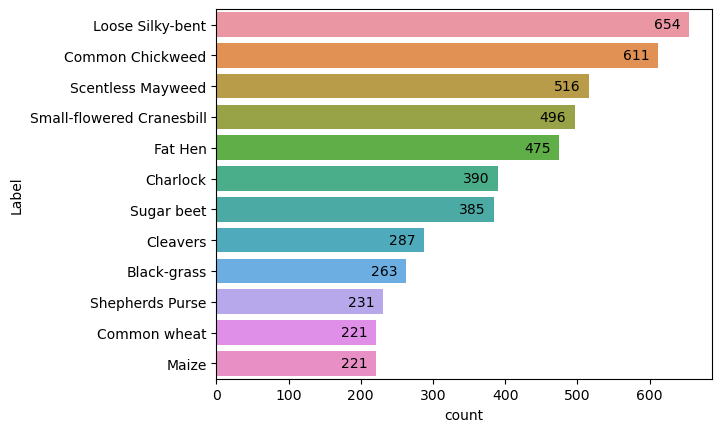

In [6]:
# Countplot showing number of data points for each category
sns.countplot(data=labels, y='Label', order=labels['Label'].value_counts().index)
for i, count in enumerate(labels['Label'].value_counts()):
    plt.annotate(count, (count - 30, i), ha='center', va='center')


There are 654 pictures of loose silky-bent seedlings which is the max, and the minimum is maize and common wheat with 221 pictures, about a third of the max. The target class imabalances can be addressed using data augementation and upsampling. 

## Data Preparation

In [7]:
# Applying gaussian blurring
for i in range(images.shape[0]):
    image = images[i]
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    images[i] = blurred_image

In [8]:
# Splitting the dataset into train and test data
X_train, X_test, y_train, y_test =  train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [10]:
# Encode target labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert encoded labels to one-hot representation
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes=12)
y_test_encoded = tf.keras.utils.to_categorical(y_test_encoded, num_classes=12)

In [11]:
# Getting the labels associated with the encoded values
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Print the mapping
for encoded_label, original_label in label_mapping.items():
    print(f"Encoded Label: {encoded_label} --> Original Label: {original_label}")

Encoded Label: 0 --> Original Label: Black-grass
Encoded Label: 1 --> Original Label: Charlock
Encoded Label: 2 --> Original Label: Cleavers
Encoded Label: 3 --> Original Label: Common Chickweed
Encoded Label: 4 --> Original Label: Common wheat
Encoded Label: 5 --> Original Label: Fat Hen
Encoded Label: 6 --> Original Label: Loose Silky-bent
Encoded Label: 7 --> Original Label: Maize
Encoded Label: 8 --> Original Label: Scentless Mayweed
Encoded Label: 9 --> Original Label: Shepherds Purse
Encoded Label: 10 --> Original Label: Small-flowered Cranesbill
Encoded Label: 11 --> Original Label: Sugar beet


## Model Building

In [12]:
# Fixing the seed for random number generators
import random
np.random.seed(5)
random.seed(5)
tf.random.set_seed(5)

To start off I will set up a CNN as follows:
* Conv layer with 3x3 kernel and 128,128,3 input shape, same as input data.
* Max Pooling to reduce output size
* Conv layer with 3x3 kernel
* Max Pooling
* Last conv layer
* Last max pooling
* Flatten
* Dense hidden layer, 100 neurons
* Output layer, 12 neurons

In [13]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Flatten())
  
model.add(Dense(100, activation='relu'))

model.add(Dense(12, activation='softmax'))

opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

2023-06-04 03:16:41.049742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=15,
            validation_split=0.1,
            shuffle=True,
            batch_size=64,
            verbose=2
)

Epoch 1/15
54/54 - 21s - loss: 2.4340 - accuracy: 0.1327 - val_loss: 2.4283 - val_accuracy: 0.1289 - 21s/epoch - 394ms/step
Epoch 2/15
54/54 - 21s - loss: 2.4012 - accuracy: 0.1620 - val_loss: 2.3353 - val_accuracy: 0.2421 - 21s/epoch - 380ms/step
Epoch 3/15
54/54 - 20s - loss: 2.1307 - accuracy: 0.2690 - val_loss: 1.9119 - val_accuracy: 0.3263 - 20s/epoch - 373ms/step
Epoch 4/15
54/54 - 20s - loss: 1.5858 - accuracy: 0.4447 - val_loss: 1.5857 - val_accuracy: 0.4737 - 20s/epoch - 369ms/step
Epoch 5/15
54/54 - 20s - loss: 1.3239 - accuracy: 0.5442 - val_loss: 1.3426 - val_accuracy: 0.5500 - 20s/epoch - 371ms/step
Epoch 6/15
54/54 - 20s - loss: 1.1616 - accuracy: 0.5944 - val_loss: 1.2118 - val_accuracy: 0.6263 - 20s/epoch - 372ms/step
Epoch 7/15
54/54 - 20s - loss: 0.9926 - accuracy: 0.6579 - val_loss: 1.1896 - val_accuracy: 0.6289 - 20s/epoch - 370ms/step
Epoch 8/15
54/54 - 20s - loss: 0.8873 - accuracy: 0.6883 - val_loss: 1.1290 - val_accuracy: 0.6421 - 20s/epoch - 370ms/step
Epoch 9/

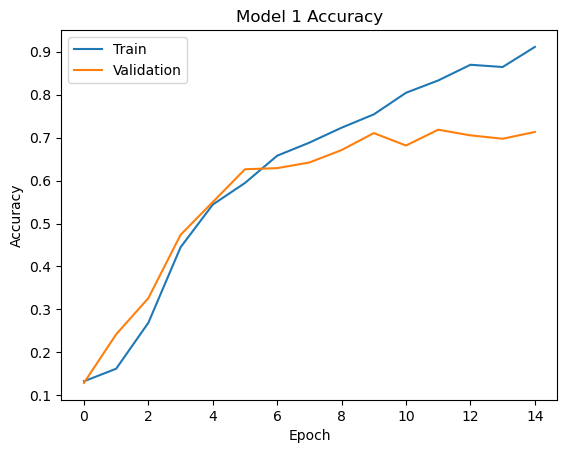

In [15]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The results from this model are very promising, training accuracy reached 90%, and validation accuracy peaked around 70%. Considering both were still on an upwards trend at 15 epochs I will run the same model for 20 epochs to see if performance improves. 

In [14]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [15]:
# Running same model for 20 epochs
history_2 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=20,
            validation_split=0.1,
            shuffle=True,
            batch_size=64,
            verbose=2
)

Epoch 1/20
54/54 - 21s - loss: 2.4340 - accuracy: 0.1327 - val_loss: 2.4283 - val_accuracy: 0.1289 - 21s/epoch - 382ms/step
Epoch 2/20
54/54 - 20s - loss: 2.4012 - accuracy: 0.1620 - val_loss: 2.3353 - val_accuracy: 0.2421 - 20s/epoch - 372ms/step
Epoch 3/20
54/54 - 20s - loss: 2.1307 - accuracy: 0.2690 - val_loss: 1.9119 - val_accuracy: 0.3263 - 20s/epoch - 370ms/step
Epoch 4/20
54/54 - 20s - loss: 1.5858 - accuracy: 0.4447 - val_loss: 1.5857 - val_accuracy: 0.4737 - 20s/epoch - 371ms/step
Epoch 5/20
54/54 - 20s - loss: 1.3239 - accuracy: 0.5442 - val_loss: 1.3426 - val_accuracy: 0.5500 - 20s/epoch - 370ms/step
Epoch 6/20
54/54 - 20s - loss: 1.1616 - accuracy: 0.5944 - val_loss: 1.2118 - val_accuracy: 0.6263 - 20s/epoch - 370ms/step
Epoch 7/20
54/54 - 20s - loss: 0.9926 - accuracy: 0.6579 - val_loss: 1.1896 - val_accuracy: 0.6289 - 20s/epoch - 370ms/step
Epoch 8/20
54/54 - 20s - loss: 0.8873 - accuracy: 0.6883 - val_loss: 1.1290 - val_accuracy: 0.6421 - 20s/epoch - 371ms/step
Epoch 9/

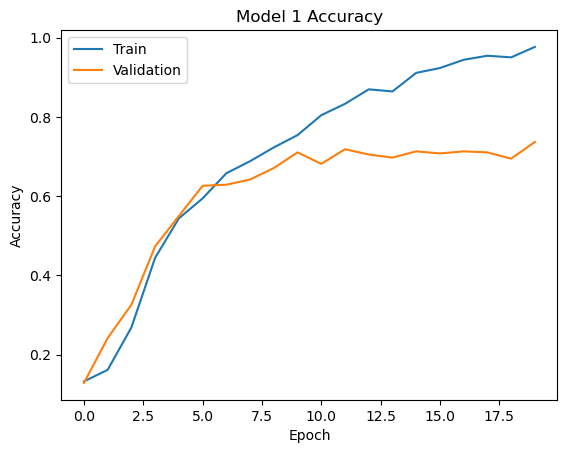

In [81]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

With 20 epochs the model's validation accuracy seems to plateu at about 70% while the training accuracy hits 100%. This may be a sign of overfitting. 

In [17]:
model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 1s - loss: 1.1911 - accuracy: 0.7747 - 1s/epoch - 45ms/step


[1.1910896301269531, 0.7747368216514587]

In [68]:
# Generating predictions on test data to create confusion matrix. 
y_pred=model.predict(X_test_normalized)

30/30 [==============================] - 1s 46ms/step


In [62]:
# Creating dataframe to store metrics for all models
data = {'Model_1': [0,0,0],
        'Model_2': [0,0,0],
        'Model_3': [0,0,0],
        'Model_4': [0,0,0]}
  
comparisonTable = pd.DataFrame(data, index=['Accuracy:',
                               'Precision:',
                               'Recall:'])

Accuracy: 0.7747368421052632
Precision: 0.7714373911664153
Recall: 0.7747368421052632


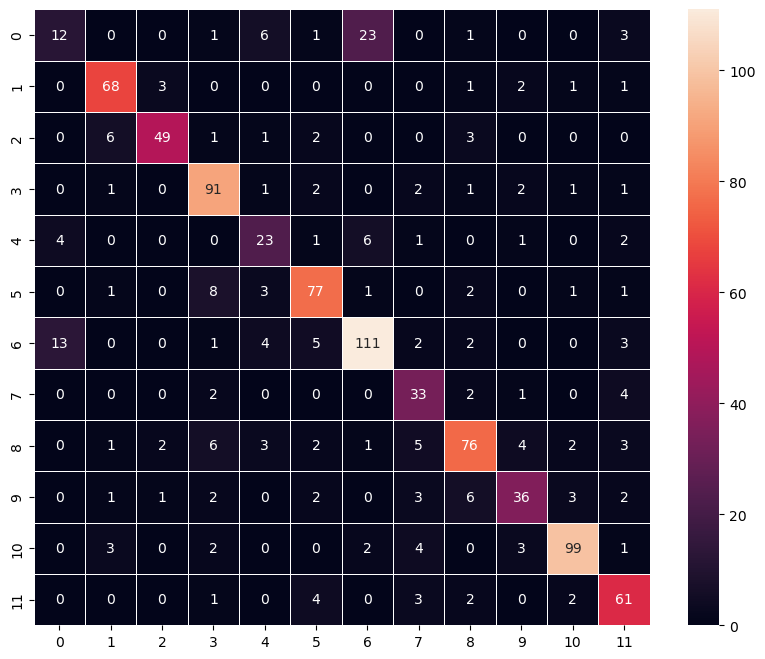

In [69]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_arg, y_pred_arg)
comparisonTable.loc['Accuracy:', 'Model_1'] = accuracy

# Calculate precision
precision = precision_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Precision:', 'Model_1'] = precision

# Calculate recall
recall = recall_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Recall:', 'Model_1'] = recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

It looks like the computer did a good job overall of classifying the plants, there are a few outliers such as a few 0s being labeled as 6s. Based on the graph showing accuracies of training and testing sets I believe that the model is overfitting. Next step will be constructing a model that is less complex to try and curb overfitting. 

In [27]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

For the next model I want to simplify it to reduce complexity and overfitting, so I will set it up as so:
* Conv layer with 3x3 kernel and 128,128,3 input shape, same as input data, only 16 neurons.
* Max Pooling to reduce output size
* Conv layer with 3x3 kernel, 8 neurons.
* Max Pooling
* Last conv layer, 8 neurons
* Last max pooling
* Flatten
* Dense hidden layer, 20 neurons
* Output layer, 12 neurons

In [28]:
model_1 = Sequential()

model_1.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Flatten())
  
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(12, activation='softmax'))

opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 8)        0

In [29]:
#Running the model for 40 epochs
history_1 = model_1.fit(
            X_train_normalized, y_train_encoded,
            epochs=40,
            validation_split=0.1,
            shuffle=True,
            batch_size=64,
            verbose=2
)

Epoch 1/40
54/54 - 4s - loss: 2.4492 - accuracy: 0.1345 - val_loss: 2.4649 - val_accuracy: 0.1289 - 4s/epoch - 82ms/step
Epoch 2/40
54/54 - 4s - loss: 2.3979 - accuracy: 0.1886 - val_loss: 2.3385 - val_accuracy: 0.1868 - 4s/epoch - 77ms/step
Epoch 3/40
54/54 - 4s - loss: 2.1754 - accuracy: 0.2535 - val_loss: 1.8332 - val_accuracy: 0.3711 - 4s/epoch - 75ms/step
Epoch 4/40
54/54 - 4s - loss: 1.8543 - accuracy: 0.3708 - val_loss: 1.8514 - val_accuracy: 0.3974 - 4s/epoch - 76ms/step
Epoch 5/40
54/54 - 4s - loss: 1.5960 - accuracy: 0.4471 - val_loss: 1.6611 - val_accuracy: 0.4789 - 4s/epoch - 76ms/step
Epoch 6/40
54/54 - 4s - loss: 1.4856 - accuracy: 0.4854 - val_loss: 1.5723 - val_accuracy: 0.4526 - 4s/epoch - 76ms/step
Epoch 7/40
54/54 - 4s - loss: 1.3462 - accuracy: 0.5325 - val_loss: 1.4783 - val_accuracy: 0.4947 - 4s/epoch - 75ms/step
Epoch 8/40
54/54 - 4s - loss: 1.2342 - accuracy: 0.5655 - val_loss: 1.3750 - val_accuracy: 0.5816 - 4s/epoch - 75ms/step
Epoch 9/40
54/54 - 4s - loss: 1.

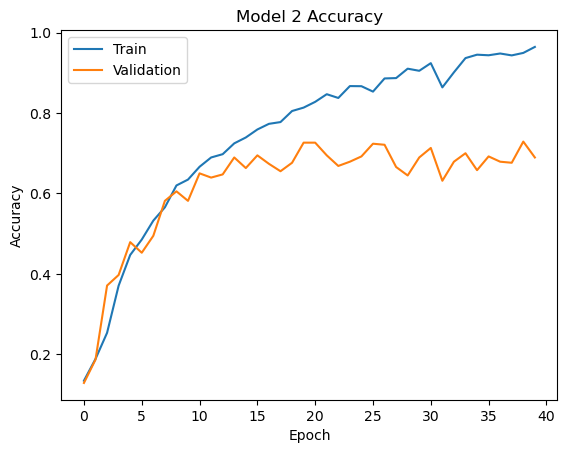

In [80]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
model_1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 0s - loss: 2.0130 - accuracy: 0.6821 - 405ms/epoch - 13ms/step


[2.0129575729370117, 0.6821052432060242]

In [70]:
# Generating predictions on test data to create confusion matrix. 
y_pred=model_1.predict(X_test_normalized)

30/30 [==============================] - 0s 14ms/step


Accuracy: 0.6821052631578948
Precision: 0.7080682199382777
Recall: 0.6821052631578948


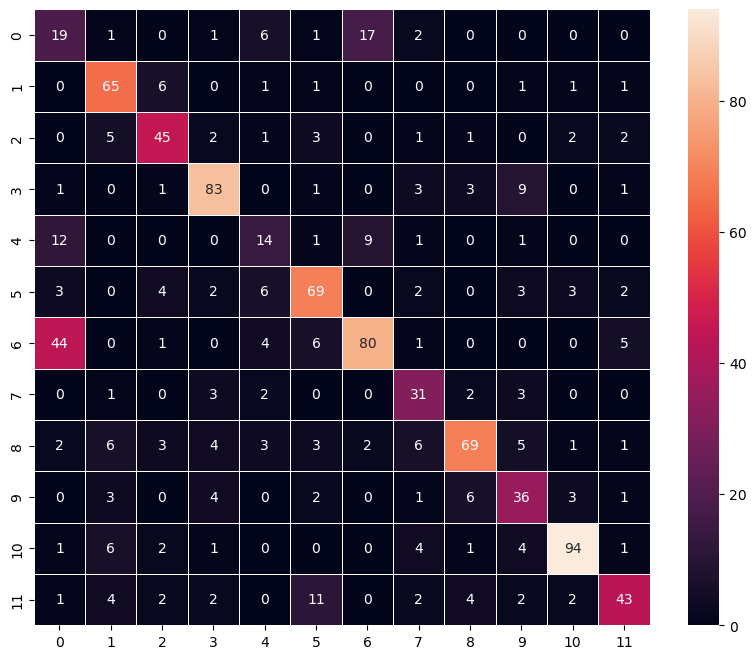

In [71]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_arg, y_pred_arg)
comparisonTable.loc['Accuracy:', 'Model_2'] = accuracy

# Calculate precision
precision = precision_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Precision:', 'Model_2'] = precision

# Calculate recall
recall = recall_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Recall:', 'Model_2'] = recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

This model seems like it is an underfit. Almost all od the black grass and common wheat were classified as loose silky bent. They all have long strands, but there are small details that differentiate them, those details are being lost by the model, indicating an underfit. Let's try to strike a balance by adding back a little bit of complexity. 

In [35]:
backend.clear_session()

For this CNN model I want to add back some complexity:
* Conv layer with 3x3 kernel and 128,128,3 input shape, same as input data, 16 neurons.
* Max Pooling to reduce output size
* Conv layer with 3x3 kernel, 16 neurons.
* Max Pooling
* Last conv layer, 8 neurons
* Last max pooling
* Flatten
* Dense hidden layer, 50 neurons
* Second dense hidden layer, 20 neurons
* Output layer, 12 neurons

In [36]:
model_2 = Sequential()

model_2.add(Conv2D(48, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(Flatten())
  
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(12, activation='softmax'))

opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 48)      1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        13856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [37]:
# Running the model for 20 epochs
history_3 = model_2.fit(
            X_train_normalized, y_train_encoded,
            epochs=20,
            validation_split=0.1,
            shuffle=True,
            batch_size=64,
            verbose=2
)

Epoch 1/20
54/54 - 16s - loss: 2.4328 - accuracy: 0.1365 - val_loss: 2.4244 - val_accuracy: 0.1289 - 16s/epoch - 306ms/step
Epoch 2/20
54/54 - 16s - loss: 2.4172 - accuracy: 0.1564 - val_loss: 2.4022 - val_accuracy: 0.2158 - 16s/epoch - 303ms/step
Epoch 3/20
54/54 - 16s - loss: 2.3687 - accuracy: 0.2111 - val_loss: 2.2927 - val_accuracy: 0.1921 - 16s/epoch - 293ms/step
Epoch 4/20
54/54 - 16s - loss: 1.9830 - accuracy: 0.3269 - val_loss: 1.8069 - val_accuracy: 0.3605 - 16s/epoch - 293ms/step
Epoch 5/20
54/54 - 16s - loss: 1.6127 - accuracy: 0.4216 - val_loss: 1.5726 - val_accuracy: 0.4132 - 16s/epoch - 293ms/step
Epoch 6/20
54/54 - 16s - loss: 1.4363 - accuracy: 0.4772 - val_loss: 1.5572 - val_accuracy: 0.4526 - 16s/epoch - 293ms/step
Epoch 7/20
54/54 - 16s - loss: 1.2805 - accuracy: 0.5509 - val_loss: 1.3577 - val_accuracy: 0.5211 - 16s/epoch - 292ms/step
Epoch 8/20
54/54 - 16s - loss: 1.1354 - accuracy: 0.6018 - val_loss: 1.3026 - val_accuracy: 0.5553 - 16s/epoch - 293ms/step
Epoch 9/

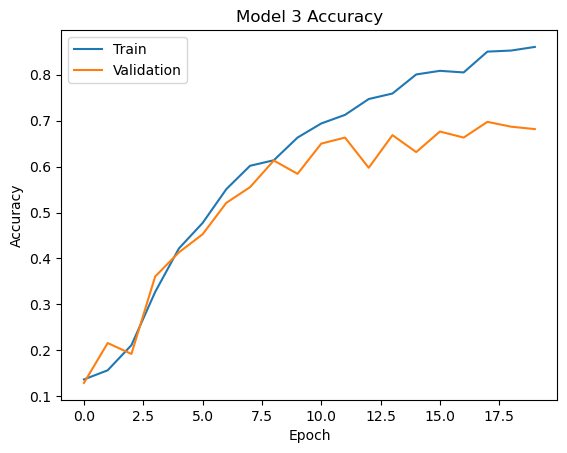

In [82]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
model_2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 1s - loss: 1.1654 - accuracy: 0.6916 - 1s/epoch - 36ms/step


[1.1653906106948853, 0.6915789246559143]

In [77]:
# Generating predictions on test data to create confusion matrix. 
y_pred=model_2.predict(X_test_normalized)

30/30 [==============================] - 1s 35ms/step


Accuracy: 0.6915789473684211
Precision: 0.7000807264714421
Recall: 0.6915789473684211


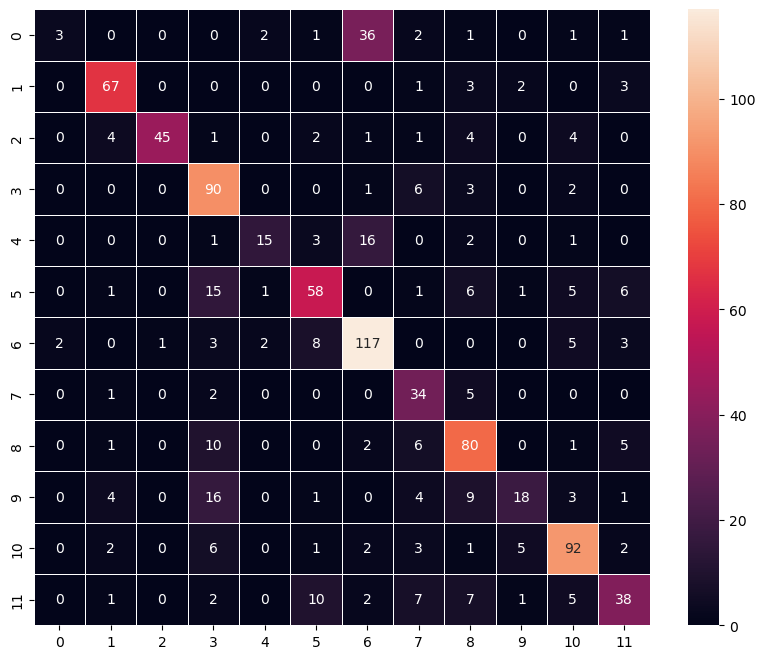

In [78]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_arg, y_pred_arg)
comparisonTable.loc['Accuracy:', 'Model_3'] = accuracy

# Calculate precision
precision = precision_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Precision:', 'Model_3'] = precision

# Calculate recall
recall = recall_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Recall:', 'Model_3'] = recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

On the third attempt the model is still misclassifying similar looking plants like 0, 4, and 6. This indicates that it is still missing out on some of the minute details. Since it would take forever to train a model capable of picking up such details on my computer, I will use transfer learning to try and accomplish this. 

In [41]:
backend.clear_session()

For the last try I will build a high complexity model to see if we can build on the performance of the very first model.
* Conv layer with 3x3 kernel and 128,128,3 input shape, same as input data, 100 neurons.
* Max Pooling to reduce output size
* Conv layer with 3x3 kernel, 50 neurons.
* Max Pooling
* Last conv layer, 50 neurons
* Last max pooling
* Flatten
* Dense hidden layer, 100 neurons
* Second dense hidden layer, 50 neurons
* Output layer, 12 neurons

In [55]:
model_3 = Sequential()

model_3.add(Conv2D(100, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_3.add(MaxPooling2D((2, 2), padding = 'same'))
model_3.add(Conv2D(50, (3, 3), activation='relu', padding="same"))
model_3.add(MaxPooling2D((2, 2), padding = 'same'))
model_3.add(Conv2D(50, (3, 3), activation='relu', padding="same"))
model_3.add(MaxPooling2D((2, 2), padding = 'same'))

model_3.add(Flatten())
  
model_3.add(Dense(100, activation='relu'))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dense(12, activation='softmax'))

opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate model summary
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 100)     2800      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 100)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 50)        45050     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 50)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 50)        22550     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 50)      

In [56]:
# Running the model for 20 epochs
history_4 = model_3.fit(
            X_train_normalized, y_train_encoded,
            epochs=20,
            validation_split=0.1,
            shuffle=True,
            batch_size=64,
            verbose=2
)

Epoch 1/20
54/54 - 39s - loss: 2.4345 - accuracy: 0.1401 - val_loss: 2.4308 - val_accuracy: 0.1289 - 39s/epoch - 720ms/step
Epoch 2/20
54/54 - 39s - loss: 2.3825 - accuracy: 0.1705 - val_loss: 2.2427 - val_accuracy: 0.1789 - 39s/epoch - 717ms/step
Epoch 3/20
54/54 - 38s - loss: 2.0939 - accuracy: 0.2807 - val_loss: 1.8038 - val_accuracy: 0.3553 - 38s/epoch - 711ms/step
Epoch 4/20
54/54 - 38s - loss: 1.6264 - accuracy: 0.4292 - val_loss: 1.6312 - val_accuracy: 0.4289 - 38s/epoch - 698ms/step
Epoch 5/20
54/54 - 37s - loss: 1.4472 - accuracy: 0.4883 - val_loss: 1.5383 - val_accuracy: 0.4895 - 37s/epoch - 694ms/step
Epoch 6/20
54/54 - 37s - loss: 1.3745 - accuracy: 0.5126 - val_loss: 1.3137 - val_accuracy: 0.5658 - 37s/epoch - 694ms/step
Epoch 7/20
54/54 - 38s - loss: 1.1146 - accuracy: 0.6020 - val_loss: 1.2440 - val_accuracy: 0.5711 - 38s/epoch - 696ms/step
Epoch 8/20
54/54 - 38s - loss: 0.9824 - accuracy: 0.6345 - val_loss: 1.3034 - val_accuracy: 0.5684 - 38s/epoch - 696ms/step
Epoch 9/

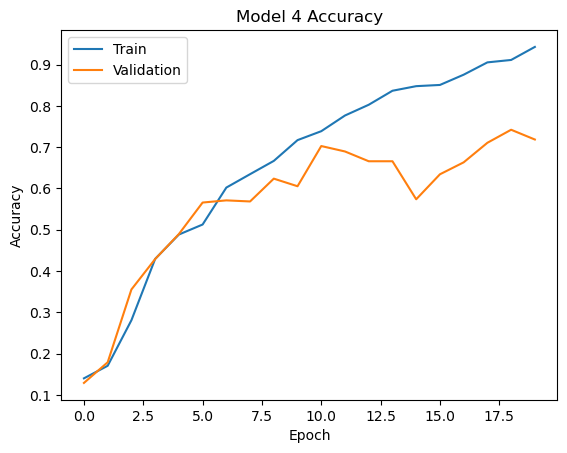

In [83]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [57]:
model_3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 3s - loss: 1.0984 - accuracy: 0.7453 - 3s/epoch - 115ms/step


[1.0983684062957764, 0.7452631592750549]

In [75]:
# Generating predictions on test data to create confusion matrix. 
y_pred=model_3.predict(X_test_normalized)

30/30 [==============================] - 3s 114ms/step


Accuracy: 0.7452631578947368
Precision: 0.7532666622732138
Recall: 0.7452631578947368


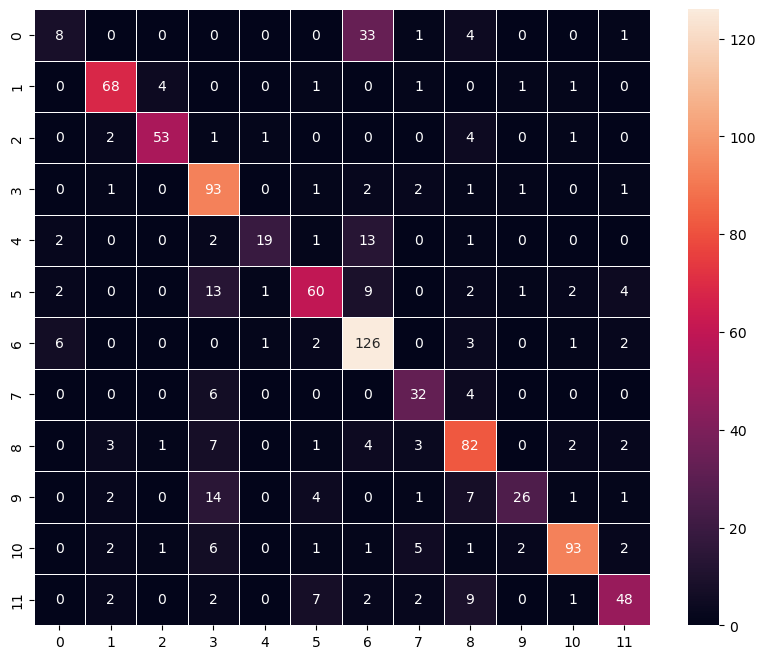

In [76]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_arg, y_pred_arg)
comparisonTable.loc['Accuracy:', 'Model_4'] = accuracy

# Calculate precision
precision = precision_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Precision:', 'Model_4'] = precision

# Calculate recall
recall = recall_score(y_test_arg, y_pred_arg, average='weighted')
comparisonTable.loc['Recall:', 'Model_4'] = recall

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

These results seem to show that more complexity is not the answer for this problem as the results are not higher than the very first model. 

In [79]:
display(comparisonTable)

,Model_1,Model_2,Model_3,Model_4
Accuracy:,0.774737,0.682105,0.691579,0.745263
Precision:,0.771437,0.708068,0.700081,0.753267
Recall:,0.774737,0.682105,0.691579,0.745263


* Model_1 -> First guess for model size and architecture
* Model_2 -> Simple model
* Model_3 -> Higher complexity than Model_2, less than 1
* Model_4 -> Most complex

It turns out that the first guess I used for the model complexity ended up being the best performer overall. In the beginning I thought that the first model was an overfit, but it turns that it wasn't since the more complex model is performing worse. Overall, I think that this task requires a high level for complexity to account for all the detail in the images, but also needs to avoid overfitting. One approach I did not get to try was a transfer learning approach, since I wasn't able to find a suitable pre-trained model to try for the dataset. This might have given the model an edge with the data since currently, the bottleneck is probably the data. If I were to do the project again I would also incorporate some kind of transformations on the images to create more data as well as more robust data, This would also help address the class imbalances present in the dataset. 